This notebook shows model and empirical scenarios.
# 1. Model experiment

## 1.1 Generating a reference trajectory

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import lfilter
from StatTools.analysis.dpcca import dpcca

In [89]:
config = {
    "overlap_step": 1,
    "hurst_min": 0.5,
    "hurst_max": 2.0,
    "rate": 12,
    "threads": 4,
}
s_array = np.array([2**i for i in range(3, config["rate"] - 2)])
h_list = [
    i * 0.01
    for i in range(
        int(config["hurst_min"] * 100), int(config["hurst_max"] * 100) + 1, 25
    )
]
trj_len = 2 ** config["rate"]

In [90]:
tab_colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
]

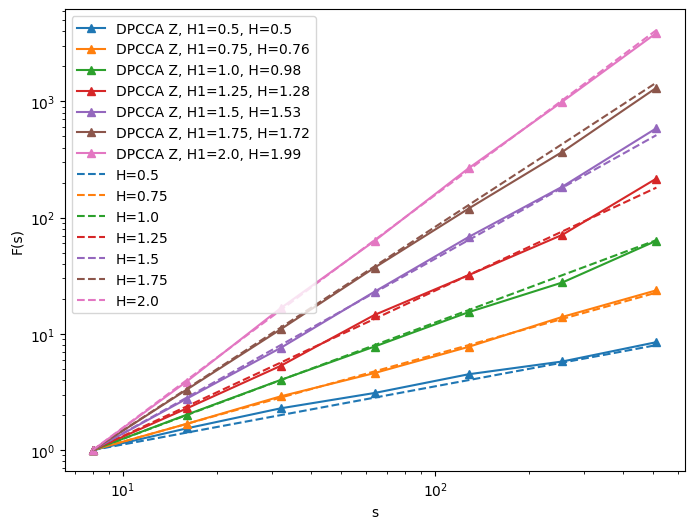

In [91]:
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_list):
    X = np.random.randn(1, trj_len).flatten()
    B = (h - 0.5) * (np.arange(1, trj_len + 1)**(h - 1.5))
    beta = 2 * h - 1
    A = np.zeros_like(B)
    A[0] = 1.0
    for k in range(1, trj_len):
        A[k] = (k - 1 - beta / 2) * A[k - 1] / k
    Z = lfilter(np.ones(len(A)), A, X)
    sig_z = np.array(Z)

    p_z, r_z, f_z, s_z = dpcca(sig_z, 2, config["overlap_step"], s_array, processes=config["threads"], n_integral=0)
    f_z = np.sqrt(f_z) 
    f_z /= f_z[0]
    res = stats.linregress(np.log(s_z), np.log(f_z)).slope
    plt.loglog(s_array, f_z, '^-', label=f'DPCCA Z, H1={round(h, 2)}, H={round(res, 2)}', color=tab_colors[i])
for i, h in enumerate(h_list):
    plt.loglog(s_array, [s**h / s_array[0]**h for s in s_array], tab_colors[i], label=f'H={round(h, 2)}', linestyle='--')
plt.xlabel('s')
plt.ylabel('F(s)')
plt.legend()
plt.show()

In [92]:
signal_ds = np.ones((10, trj_len))

In [93]:
h = 0.8
B = (h - 0.5) * (np.arange(1, trj_len + 1)**(h - 1.5))
beta = 2 * h - 1
A = np.zeros_like(B)
A[0] = 1.0
for k in range(1, trj_len):
    A[k] = (k - 1 - beta / 2) * A[k - 1] / k
for i in range(10):
    x_array = np.random.randn(1, trj_len).flatten()
    signal = np.array(lfilter(np.ones(len(A)), A, x_array))
    signal_ds[i] = signal

## 1.2 Imitation of distortion

In [94]:
def add_noise(signal, snr_db):
    """
    Adds white Gaussian noise to a signal with a given SNR (in dB).
    
    Parameters:
        signal (np.array): The original signal.
        snr_db (float): The desired signal-to-noise ratio in decibels.
    
    Returns:
        np.array: A noisy signal.
    """
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise
    
    return noisy_signal

def add_gaps_fixed(signal, gap_duration, gap_frequency):
    """
    Adds gaps of fixed duration at certain intervals.
    
    Parameters:
        signal (np.array): The original signal.
        gap_duration (int): The duration of each pass in the reports.
        gap_frequency (int): The frequency of skips (every nth count).
    
    Returns:
        np.array: A signal with gaps (filled with NaN).
        np.array: Skip mask (1 - there is data, 0 - skip).
    """
    signal_with_gaps = signal.copy()
    mask = np.ones(len(signal), dtype=bool)
    
    for i in range(10, len(signal) - 10, gap_frequency):
        start = i
        end = min(i + gap_duration, len(signal))
        signal_with_gaps[start:end] = np.nan
        mask[start:end] = 0
    
    return signal_with_gaps, mask

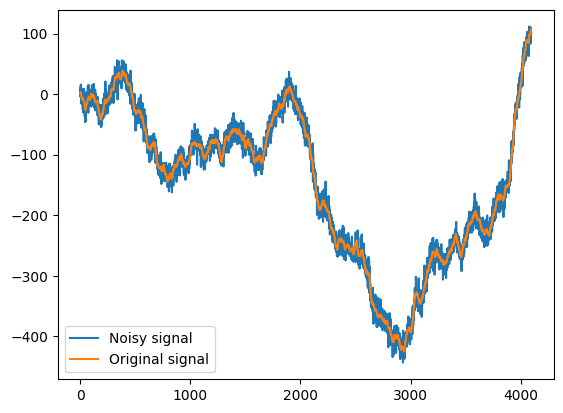

In [95]:
noisy_signal = add_noise(signal_ds[0], snr_db=25)
plt.plot(noisy_signal, label='Noisy signal')
plt.plot(signal_ds[0], label='Original signal')
plt.legend()
plt.show()

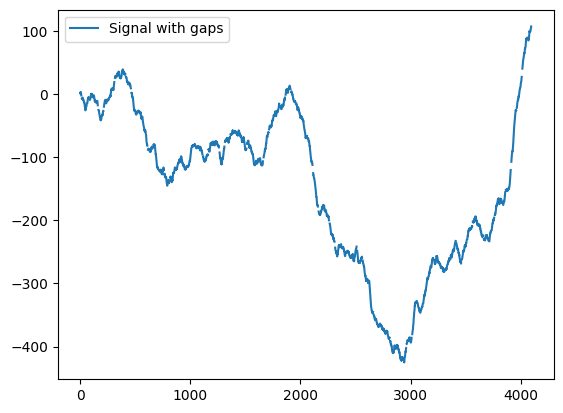

In [96]:
signal_with_gaps, gap_mask = add_gaps_fixed(signal_ds[0], gap_duration=5, gap_frequency=50)
plt.plot(signal_with_gaps, label='Signal with gaps')
plt.legend()
plt.show()

## 1.3 Reconstituting of trajectories

### lbfbm generator

In [97]:
from StatTools.generators.lbfbm_generator import LBFBmGenerator
from StatTools.analysis.dfa import DFA

In [98]:
dfa = DFA(np.diff(signal_ds[0]))
h = round(dfa.find_h(), 2)
base = 1.1
target_len = signal_ds[0].shape[0]

initial_std = np.nanstd(np.diff(signal_with_gaps))
random_values = np.random.randn(target_len) * initial_std
random_iter = iter(random_values)

generator = LBFBmGenerator(h, base, 
                          random_generator=random_iter,
                          length=target_len)

recovered_signal = np.zeros(target_len)
generated_signal = np.zeros(target_len)
for i in range(target_len):
    if np.isnan(signal_with_gaps[i]):
        x = next(generator)
        recovered_signal[i] = x + recovered_signal[i-1]
        generated_signal[i] = x
        print(f"gap\ngen:{x:.2f}, orig:{signal_with_gaps[i]:.2f}")
    else:
        if i == 0:
            x = generator.next_with_value(0)
        else:
            x = generator.next_with_value(signal_with_gaps[i] - recovered_signal[i-1])
        print(f"gen:{x:.2f}, orig:{signal_with_gaps[i]:.2f}")
        recovered_signal[i] = signal_with_gaps[i]
        generated_signal[i] = x

gen:0.00, orig:0.80
gen:1.38, orig:2.18
gen:0.47, orig:2.21
gen:-0.60, orig:1.31
gen:1.66, orig:3.03
gen:0.11, orig:2.59
gen:-0.21, orig:2.14
gen:-1.66, orig:0.41
gen:-1.21, orig:-0.34
gen:-2.53, orig:-2.36
gap
gen:-2.78, orig:nan
gap
gen:-1.56, orig:nan
gap
gen:-0.65, orig:nan
gap
gen:-1.19, orig:nan
gap
gen:-2.55, orig:nan
gen:2.30, orig:-7.57
gen:-0.41, orig:-8.17
gen:-0.32, orig:-8.25
gen:0.37, orig:-7.61
gen:0.64, orig:-6.93
gen:0.62, orig:-6.43
gen:0.86, orig:-5.76
gen:-0.84, orig:-6.91
gen:-0.98, orig:-7.72
gen:-1.92, orig:-9.27
gen:-1.04, orig:-9.55
gen:-0.82, orig:-9.74
gen:-0.31, orig:-9.48
gen:0.10, orig:-8.99
gen:-0.90, orig:-9.68
gen:-1.45, orig:-10.66
gen:-1.58, orig:-11.53
gen:-0.80, orig:-11.48
gen:-0.96, orig:-11.76
gen:-2.12, orig:-13.20
gen:-1.37, orig:-13.52
gen:-0.16, orig:-12.74
gen:-1.51, orig:-13.70
gen:-1.58, orig:-14.43
gen:-3.13, orig:-16.61
gen:-2.49, orig:-17.62
gen:-2.86, orig:-19.00
gen:-3.96, orig:-21.32
gen:-2.62, orig:-21.87
gen:-3.40, orig:-23.45
gen:

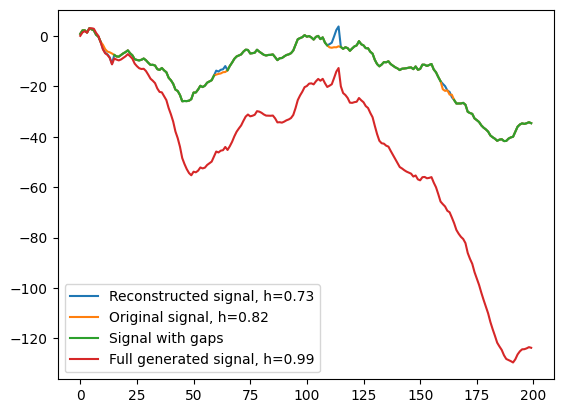

In [99]:
dfa = DFA(np.diff(recovered_signal))
h = round(dfa.find_h(), 2)
plt.plot(recovered_signal[0:200], label=f'Reconstructed signal, h={h}')
dfa = DFA(np.diff(signal_ds[0]))
h = round(dfa.find_h(), 2)
plt.plot(signal_ds[0][0:200], label=f'Original signal, h={h}')
plt.plot(signal_with_gaps[0:200], label=f'Signal with gaps')
dfa = DFA(generated_signal)
h = round(dfa.find_h(), 2)
plt.plot(np.cumsum(generated_signal)[0:200], label=f'Full generated signal, h={h}')
# plt.plot(signal_ds[0] - recovered_signal)
plt.legend()
plt.show()

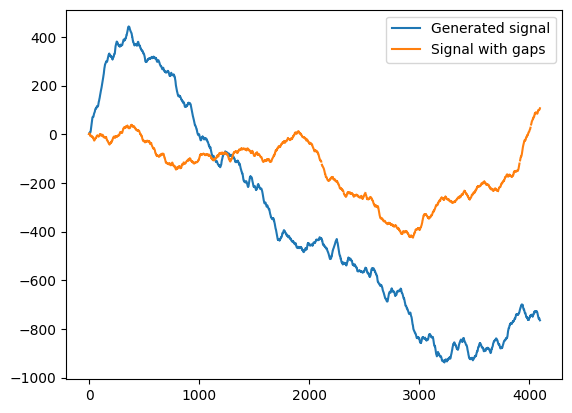

In [100]:
gen_signal = np.zeros(target_len)

initial_std = np.nanstd(np.diff(signal_with_gaps))
random_values = np.random.randn(target_len) * initial_std
random_iter = iter(random_values)

generator = LBFBmGenerator(h, base, 
                          random_generator=random_iter,
                          length=target_len)

for i in range(target_len):
    x = next(generator)
    gen_signal[i] = x
plt.plot(np.cumsum(gen_signal), label='Generated signal')
plt.plot(signal_with_gaps, label='Signal with gaps')
plt.legend()
plt.show()

## 1.4 Evaluation and analysis of results